# ChemCPA

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from seml.config import generate_configs, read_config

from madrigal.chemcpa.chemCPA.experiments_run import TxAdaptingExperimentWrapper

from madrigal.utils import BASE_DIR, DATA_DIR

VIEW_OUTPUT_DIR = DATA_DIR + "views_features_new/"

We start from the weights pretrained from L1000 by Hetzel et al. (2022).

### Generate RDKit embeddings

Note: Since we normalize the RDKit embeddings for each feature dimension, the RDKit embedding distribution during pretraining (Tx adapting compounds) is different from the one during contrastive pretraining and DDI finetuning (curated compounds).

In [ ]:
dataset_name = 'all'

# For curated compounds
drug_metadata = pd.read_pickle(VIEW_OUTPUT_DIR+'combined_metadata_ddi.pkl')
drug_metadata['view_tx'] = (drug_metadata[[col for col in drug_metadata.columns if col.startswith('view_tx_')]].sum(axis=1) >= 1).astype(int)
smiles_list_comb = drug_metadata['canonical_smiles'].values

# For TX pretraining
tx_cp_metadata_for_adapting = pd.read_pickle(VIEW_OUTPUT_DIR+'tx/tx_cp_metadata_for_adapting.pkl')
assert np.all(np.sort(tx_cp_metadata_for_adapting['canonical_smiles'].unique()) == tx_cp_metadata_for_adapting['canonical_smiles'].unique())
smiles_list_adapting = tx_cp_metadata_for_adapting['canonical_smiles'].unique()

smiles_list = np.unique(np.concatenate([smiles_list_comb, smiles_list_adapting]))

In [3]:
print(f'Number of smiles strings: {len(smiles_list)}')

Number of smiles strings: 22398


In [4]:
from descriptastorus.descriptors.DescriptorGenerator import MakeGenerator
generator = MakeGenerator(("RDKit2D",))
for name, numpy_type in generator.GetColumns():
    print(f"{name}({numpy_type.__name__})")

RDKit2D_calculated(bool)
BalabanJ(float64)
BertzCT(float64)
Chi0(float64)
Chi0n(float64)
Chi0v(float64)
Chi1(float64)
Chi1n(float64)
Chi1v(float64)
Chi2n(float64)
Chi2v(float64)
Chi3n(float64)
Chi3v(float64)
Chi4n(float64)
Chi4v(float64)
EState_VSA1(float64)
EState_VSA10(float64)
EState_VSA11(float64)
EState_VSA2(float64)
EState_VSA3(float64)
EState_VSA4(float64)
EState_VSA5(float64)
EState_VSA6(float64)
EState_VSA7(float64)
EState_VSA8(float64)
EState_VSA9(float64)
ExactMolWt(float64)
FpDensityMorgan1(float64)
FpDensityMorgan2(float64)
FpDensityMorgan3(float64)
FractionCSP3(float64)
HallKierAlpha(float64)
HeavyAtomCount(float64)
HeavyAtomMolWt(float64)
Ipc(float64)
Kappa1(float64)
Kappa2(float64)
Kappa3(float64)
LabuteASA(float64)
MaxAbsEStateIndex(float64)
MaxAbsPartialCharge(float64)
MaxEStateIndex(float64)
MaxPartialCharge(float64)
MinAbsEStateIndex(float64)
MinAbsPartialCharge(float64)
MinEStateIndex(float64)
MinPartialCharge(float64)
MolLogP(float64)
MolMR(float64)
MolWt(float64)

In [5]:
n_jobs = 4
data = Parallel(n_jobs=n_jobs, backend="threading")(delayed(generator.process)(smiles) for smiles in tqdm(smiles_list, position=0, leave=True) )

  0%|          | 0/22398 [00:00<?, ?it/s]

In [6]:
embedding = np.array(data)
embedding.shape

(22398, 201)

Check for `nans`

In [7]:
drug_idx, feature_idx = np.where(np.isnan(embedding))
print(f'drug_idx:\n {drug_idx}')
print(f'feature_idx:\n {feature_idx}')

drug_idx:
 [  342   342   342   342   511   511   511   511   677   677   677   677
   696   696   696   696   697   697   697   697   698   698   698   698
   699   699   699   699   700   700   700   700   701   701   701   701
   702   702   702   702   703   703   703   703  1063  1063  1063  1063
  1064  1064  1064  1064  1208  1208  1208  1208  1306  1306  1306  1306
  1307  1307  1307  1307  2804  2804  2804  2804  2924  2924  2924  2924
  3112  3112  3112  3112  3129  3129  3129  3129  3130  3130  3130  3130
  3131  3131  3131  3131  3134  3134  3134  3134  3135  3135  3135  3135
  3152  3152  3152  3152  3182  3182  3182  3182  3763  3763  3763  3763
  4026  4026  4026  4026  4530  4530  4530  4530  4547  4547  4547  4547
  5765  5765  5765  5765  5766  5766  5766  5766  6100  6100  6100  6100
  6127  6127  6127  6127  6145  6145  6145  6145  7344  7344  7344  7344
  7566  7566  7566  7566  8106  8106  8106  8106  8107  8107  8107  8107
 11255 11255 11255 11255 11256 11256 112

Check for `infs` and add to idx lists

In [8]:
drug_idx_infs, feature_idx_infs = np.where(np.isinf(embedding))

drug_idx = np.concatenate((drug_idx, drug_idx_infs))
feature_idx = np.concatenate((feature_idx, feature_idx_infs))

Features that have these invalid values:

In [9]:
np.array(generator.GetColumns())[np.unique(feature_idx)]

array([['MaxAbsPartialCharge', <class 'numpy.float64'>],
       ['MaxPartialCharge', <class 'numpy.float64'>],
       ['MinAbsPartialCharge', <class 'numpy.float64'>],
       ['MinPartialCharge', <class 'numpy.float64'>]], dtype=object)

Set values to `0`

In [10]:
embedding[drug_idx, feature_idx] 

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [12]:
embedding[drug_idx, feature_idx] = 0

Save

In [ ]:
import pandas as pd

df = pd.DataFrame(data=embedding,index=smiles_list,columns=[f'latent_{i}' for i in range(embedding.shape[1])]) 

# Drop first feature from generator (RDKit2D_calculated)
df.drop(columns=['latent_0'], inplace=True)

# Drop columns with 0 standard deviation
threshold = 1e-4
columns=[f'latent_{idx+1}' for idx in np.where(df.std() <= threshold)[0]]
print(f'Deleting columns with std <= {threshold}: {columns}')
df.drop(columns=[f'latent_{idx+1}' for idx in np.where(df.std() <= threshold)[0]], inplace=True)

Check that correct columns were deleted: 

In [ ]:
np.where(df.std() <= threshold)

Normalise dataframe

In [15]:
normalized_df = (df - df.mean()) / df.std()

Check destination folder

In [16]:
model_name = 'rdkit2D'
directory = VIEW_OUTPUT_DIR + 'tx/embeddings/'
os.makedirs(directory, exist_ok=True)

fname = f'{model_name}_embeddings_all_all_normalized.parquet'
fname_comb = f'{model_name}_embeddings_combined_all_normalized.parquet'
fname_adapting = f'{model_name}_embeddings_adapting_all_normalized.parquet'

Save normalised version

In [98]:
normalized_df.to_parquet(directory + fname)
normalized_df.loc[smiles_list_comb].to_parquet(directory + fname_comb)
normalized_df.loc[smiles_list_adapting].to_parquet(directory + fname_adapting)

### Training

In [2]:
model_name = 'rdkit2D'
directory = VIEW_OUTPUT_DIR + 'tx/embeddings/'
fname = f'{model_name}_embeddings_all_all_normalized.parquet'

normalized_df = pd.read_parquet(directory + fname)

In [ ]:
exp = TxAdaptingExperimentWrapper(init_all=False)

assert os.path.exists(
    "../../configs/chemcpa/chemcpa_tx_adapting_configs.yaml"
), "config file not found"
seml_config, slurm_config, experiment_config = read_config(
    "../../configs/chemcpa/chemcpa_tx_adapting_configs.yaml"
)
# we take the first config generated
configs = generate_configs(experiment_config)
if len(configs) > 1:
    raise Exception("More than one config generated from the yaml file")
args = configs[0]
# pprint(args)

exp.init_dataset(**args["dataset"])
exp.init_drug_embedding(embedding=args["model"]["embedding"])
exp.init_model(
    hparams=args["model"]["hparams"],
    additional_params=args["model"]["additional_params"],
    load_pretrained=args["model"]["load_pretrained"],
    append_ae_layer=args["model"]["append_ae_layer"],
    pretrained_model_path=args["model"]["pretrained_model_path"],
    pretrained_model_ckpt=args["model"]["pretrained_model_ckpt"],
    use_drugs=args["model"]["use_drugs"]
)
exp.update_datasets()

In [ ]:
res = exp.train(**args["training"])

In [ ]:
temp = torch.load(BASE_DIR + 'model_output/pretrain/adapting/tx/checkpoints/2025-02-22_12:28_tx_adapting_full_use_drugs_sweep.pt')  # replace this with the path to the actual model checkpoint
history = temp[4]

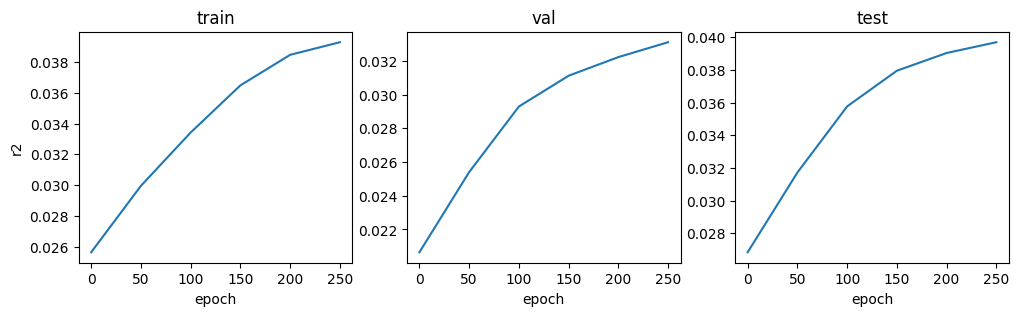

In [9]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(np.array(history['epoch'])[list(range(0, len(history['epoch']), int(len(history['epoch']) // len(history['training']))))], history['training'])
plt.xlabel('epoch')
plt.ylabel('r2')
plt.title('train')
plt.subplot(1,3,2)
plt.plot(np.array(history['epoch'])[list(range(0, len(history['epoch']), int(len(history['epoch']) // len(history['training']))))], history['val'])
plt.xlabel('epoch')
plt.title('val')
plt.subplot(1,3,3)
plt.plot(np.array(history['epoch'])[list(range(0, len(history['epoch']), int(len(history['epoch']) / len(history['training']))))], history['test'])
plt.xlabel('epoch')
plt.title('test')
plt.show()

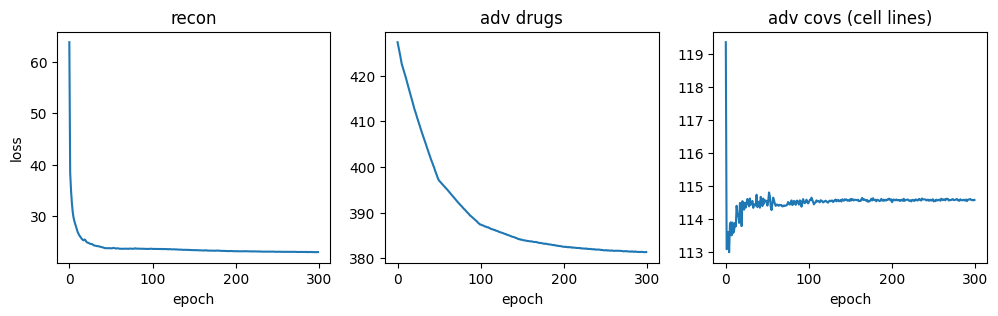

In [10]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(history['epoch'], history['loss_reconstruction'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('recon')
plt.subplot(1,3,2)
plt.plot(history['epoch'], history['loss_adv_drugs'])
plt.xlabel('epoch')
plt.title('adv drugs')
plt.subplot(1,3,3)
plt.plot(history['epoch'], history['loss_adv_covariates'])
plt.xlabel('epoch')
plt.title('adv covs (cell lines)')
plt.show()

### Sweep

#### (Transferred to script)

In [1]:
import torch, os
import pandas as pd
import numpy as np
from pathlib import Path
from pprint import pprint

from seml.config import generate_configs, read_config

from madrigal.chemcpa.chemCPA.experiments_run import TxAdaptingExperimentWrapper


In [ ]:
exp = TxAdaptingExperimentWrapper(init_all=False)

assert os.path.exists(
    "../../configs/chemcpa/chemcpa_tx_adapting_configs_sweep.yaml"
), "config file not found"
_, _, experiment_config = read_config(
    "../../configs/chemcpa/chemcpa_tx_adapting_configs_sweep.yaml"
)
# we take the first config generated
configs = generate_configs(experiment_config)
args = configs[0]
# pprint(args)

exp.init_dataset(**args["dataset"])
exp.init_drug_embedding(embedding=args["model"]["embedding"])

exp.init_model(
    hparams=args["model"]["hparams"],
    additional_params=args["model"]["additional_params"],
    load_pretrained=args["model"]["load_pretrained"],
    append_ae_layer=args["model"]["append_ae_layer"],
    pretrained_model_path=args["model"]["pretrained_model_path"],
    pretrained_model_ckpt=args["model"]["pretrained_model_ckpt"],
    use_drugs=args["model"]["use_drugs"]
)
exp.update_datasets()
all_res = [exp.train(**args["training"])]

for i in range(1, len(configs)):
    args = configs[i]
    exp.init_model(
        hparams=args["model"]["hparams"],
        additional_params=args["model"]["additional_params"],
        load_pretrained=args["model"]["load_pretrained"],
        append_ae_layer=args["model"]["append_ae_layer"],
        pretrained_model_path=args["model"]["pretrained_model_path"],
        pretrained_model_ckpt=args["model"]["pretrained_model_ckpt"],
        use_drugs=args["model"]["use_drugs"]
    )
    exp.update_datasets()
    all_res.append(exp.train(**args["training"]))

#### Investigate sweep results

In [ ]:
fnames = os.listdir(BASE_DIR + 'model_output/pretrain/adapting/tx/checkpoints/sweep/')

In [ ]:
def unpack_dict(dictionary):
    output = dict()
    for k, v in dictionary.items():
        if not isinstance(v, dict):
            output[k] = v
        else:
            temp = unpack_dict(v)
            output.update({k+'.'+kk : vv for kk, vv in temp.items()})
    return output
            
all_values = []
for fname in fnames:
    temp = torch.load(BASE_DIR + f'model_output/pretrain/adapting/tx/checkpoints/sweep/{fname}')
    hparams = temp[3]
    inst = unpack_dict(hparams)
    inst['val_final'] = temp[4]['val'][-1]
    inst['test_final'] = temp[4]['test'][-1]
    all_values.append(inst)
all_sweep_values = pd.DataFrame(all_values)

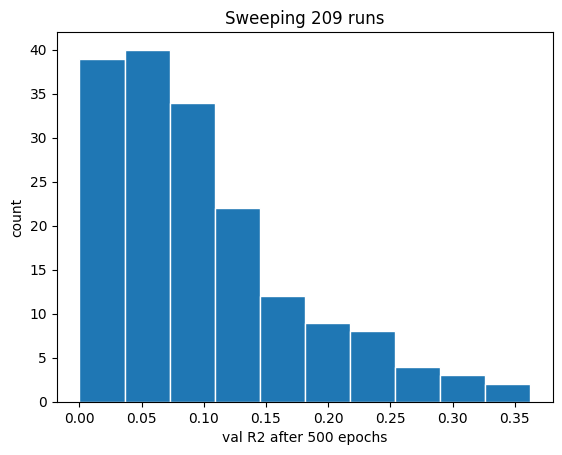

In [9]:
plt.hist(all_sweep_values['val_final'].values, ec='white', range=[0, all_sweep_values['val_final'].max()])
plt.xlabel('val R2 after 500 epochs')
plt.ylabel('count')
plt.title(f'Sweeping {all_sweep_values.shape[0]} runs')
plt.show()

In [198]:
len([col for col in all_sweep_values.columns if (col.startswith('hparams.') and col != 'hparams.dim') or col in {'use_drugs'}])

22

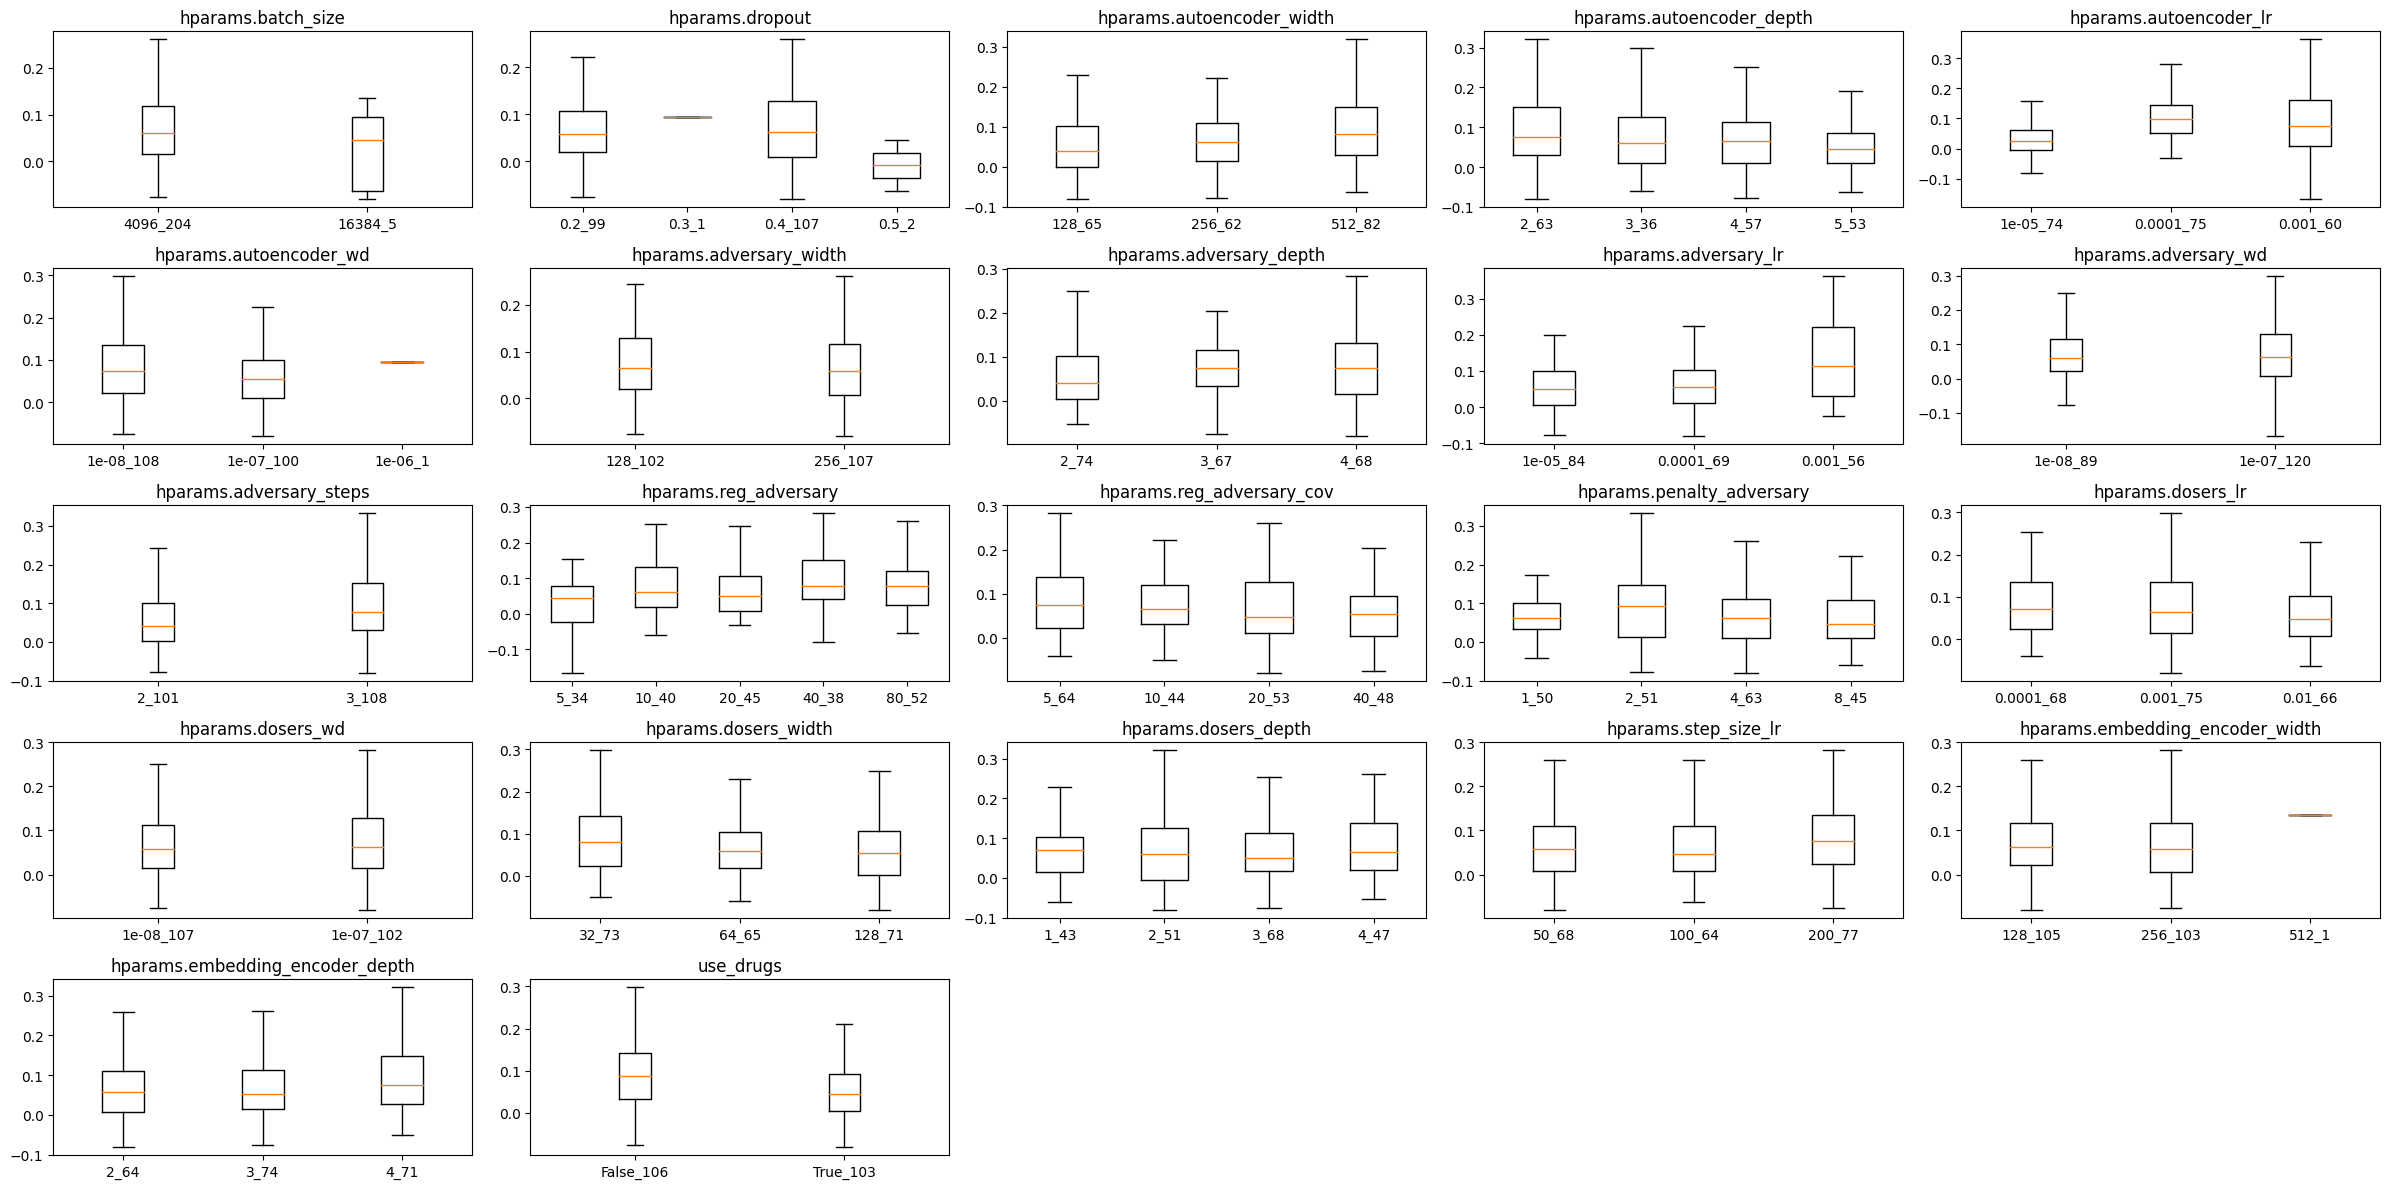

In [199]:
fig = plt.figure(figsize=(24, 12))
i = 1
for col in all_sweep_values.columns:
    if (col.startswith('hparams.') and col != 'hparams.dim') or col in {'use_drugs'}:
        ax = fig.add_subplot(5, 5, i)
        plot_data = all_sweep_values[[col, 'val_final']].groupby(col).agg(list)
        bp = ax.boxplot(plot_data['val_final'].values, showfliers=False, labels=[str(val)+'_'+str(len(plt_arr)) for val, plt_arr in zip(plot_data.index.values, plot_data['val_final'].values)])
        ax.set_title(f"{col}")
        i += 1
        
plt.tight_layout()
plt.show()

In [10]:
all_sweep_values['val_final'].argmax()

62

In [19]:
all_sweep_values.sort_values('val_final', ascending=False)['use_drugs'].head(20)

62     False
19     False
205    False
126    False
177    False
70     False
119    False
38     False
65     False
124    False
191    False
43      True
92     False
73     False
175    False
142     True
14     False
187    False
128    False
112     True
Name: use_drugs, dtype: bool

In [ ]:
temp = torch.load(BASE_DIR + f'model_output/pretrain/adapting/tx/checkpoints/sweep/{fnames[43]}')
history = temp[4]
temp[3]['use_drugs']

True

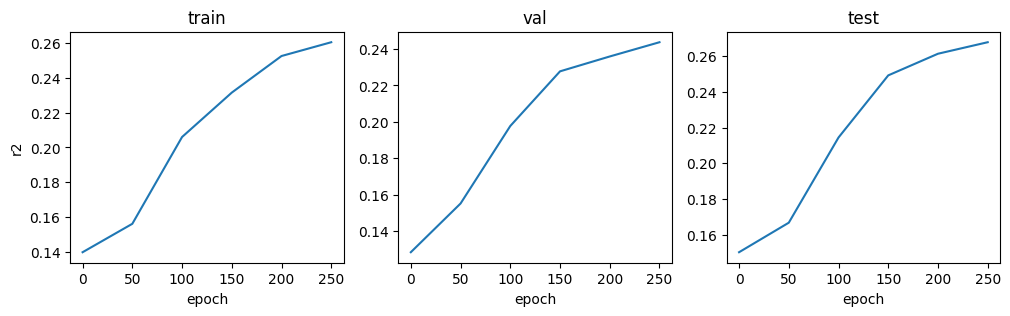

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(np.array(history['epoch'])[list(range(0, len(history['epoch']), int(len(history['epoch']) // len(history['training']))))], history['training'])
plt.xlabel('epoch')
plt.ylabel('r2')
plt.title('train')
plt.subplot(1,3,2)
plt.plot(np.array(history['epoch'])[list(range(0, len(history['epoch']), int(len(history['epoch']) // len(history['training']))))], history['val'])
plt.xlabel('epoch')
plt.title('val')
plt.subplot(1,3,3)
plt.plot(np.array(history['epoch'])[list(range(0, len(history['epoch']), int(len(history['epoch']) / len(history['training']))))], history['test'])
plt.xlabel('epoch')
plt.title('test')
plt.show()

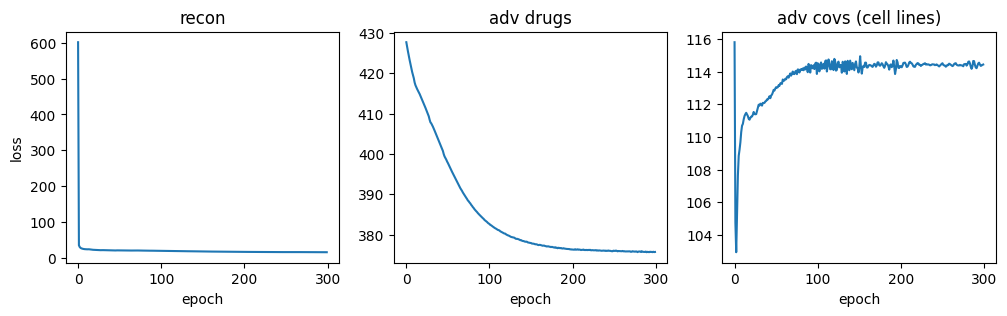

In [32]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(history['epoch'], history['loss_reconstruction'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('recon')
plt.subplot(1,3,2)
plt.plot(history['epoch'], history['loss_adv_drugs'])
plt.xlabel('epoch')
plt.title('adv drugs')
plt.subplot(1,3,3)
plt.plot(history['epoch'], history['loss_adv_covariates'])
plt.xlabel('epoch')
plt.title('adv covs (cell lines)')
plt.show()

#### Re-training best runs

In [ ]:
exp = TxAdaptingExperimentWrapper(init_all=False)

assert os.path.exists(
    "../../configs/chemcpa/chemcpa_tx_adapting_configs_sweep.yaml"
), "config file not found"
_, _, experiment_config = read_config(
    "../../configs/chemcpa/chemcpa_tx_adapting_configs_sweep.yaml"
)
# we take the first config generated
configs = generate_configs(experiment_config)
args = configs[0]
args['training']['run_eval_disentangle'] = True

exp.init_dataset(**args["dataset"])
exp.init_drug_embedding(embedding=args["model"]["embedding"])

args["model"]["hparams"] = temp[3]["hparams"]
args["model"]["use_drugs"] = temp[3]["use_drugs"]
args["model"]["additional_params"]["decoder_activation"] = temp[3]["decoder_activation"]
exp.init_model(
    hparams=args["model"]["hparams"],
    additional_params=args["model"]["additional_params"],
    load_pretrained=args["model"]["load_pretrained"],
    append_ae_layer=args["model"]["append_ae_layer"],
    pretrained_model_path=args["model"]["pretrained_model_path"],
    pretrained_model_ckpt=args["model"]["pretrained_model_ckpt"],
    use_drugs=args["model"]["use_drugs"]
)
exp.update_datasets()

In [ ]:
exp.train(**args["training"])

In [ ]:
temp = torch.load(BASE_DIR + 'model_output/pretrain/adapting/tx/checkpoints/tx_adapting_full_use_drugs.pt')  # replace with the actual checkpoint
history = temp[4]
temp[3]

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(np.array(history['epoch'])[list(range(0, len(history['epoch']), int(len(history['epoch']) // len(history['training']))))], history['training'])
plt.xlabel('epoch')
plt.ylabel('r2')
plt.title('train')
plt.subplot(1,3,2)
plt.plot(np.array(history['epoch'])[list(range(0, len(history['epoch']), int(len(history['epoch']) // len(history['training']))))], history['val'])
plt.xlabel('epoch')
plt.title('val')
plt.subplot(1,3,3)
plt.plot(np.array(history['epoch'])[list(range(0, len(history['epoch']), int(len(history['epoch']) / len(history['training']))))], history['test'])
plt.xlabel('epoch')
plt.title('test')
plt.show()

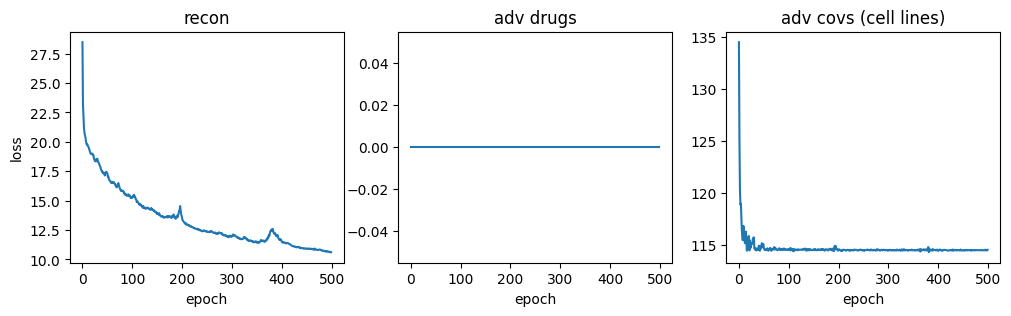

In [192]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(history['epoch'], history['loss_reconstruction'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('recon')
plt.subplot(1,3,2)
plt.plot(history['epoch'], history['loss_adv_drugs'])
plt.xlabel('epoch')
plt.title('adv drugs')
plt.subplot(1,3,3)
plt.plot(history['epoch'], history['loss_adv_covariates'])
plt.xlabel('epoch')
plt.title('adv covs (cell lines)')
plt.show()